In [3]:
import networkx as nx
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

## Integrantes

- Alessandra Belló Soares
- Matheus Fillype Ferreira de Carvalho
- Sillas Rocha da Costa

## Questão 01

In [4]:
n = 10_000  # número de vértices
target_k = 20.0  # grau médio desejado
p = target_k / (n - 1)  # Probabilidade de conexão

rng = np.random.default_rng(42)

G = nx.fast_gnp_random_graph(n, p, seed=42)

A = nx.to_scipy_sparse_array(G, format="csr", dtype=np.int8)

In [5]:
deg_list = np.array([d for _, d in G.degree()])
emp_k = deg_list.mean()
print(f"Rede criada: N={n}, k médio={emp_k:.2f}")

Rede criada: N=10000, k médio=19.97


In [6]:
def simulate_SIS_sparse(A, beta, mu, T=100, runs=100, initial_infected=5):
    rng = np.random.default_rng(42)
    n = A.shape[0]
    prevalence_runs = np.zeros((runs, T))

    for r in range(runs):
        # Estado inicial: todos suscetíveis (False), exceto 5 infectados
        infected = np.zeros(n, dtype=bool)
        seeds = rng.choice(n, initial_infected, replace=False)
        infected[seeds] = True

        for t in range(T):
            # Registra a fração de infectados no tempo t
            prevalence_runs[r, t] = infected.mean()

            # 1. Processo de Recuperação I para S
            # Cada nó infectado se recupera com probabilidade mu
            recover_prob = rng.random(n)
            just_recovered = infected & (recover_prob < mu)
            infected[just_recovered] = False

            # 2. Processo de Infecção S para I
            # Contar vizinhos infectados para cada nó
            inf_neighbors_count = A.dot(infected.astype(np.int8))
            susceptible = ~infected
            k_inf = inf_neighbors_count[susceptible]

            p_infection = 1.0 - np.power(1.0 - beta, k_inf)

            new_inf_mask = rng.random(len(k_inf)) < p_infection

            infected[susceptible] = new_inf_mask

    # Calcula média e desvio padrão entre as execuções
    mean_prev = prevalence_runs.mean(axis=0)
    std_prev = prevalence_runs.std(axis=0)

    return mean_prev, std_prev

Simulando: β=0.02, μ=0.1 (R0 ≈ 3.99)


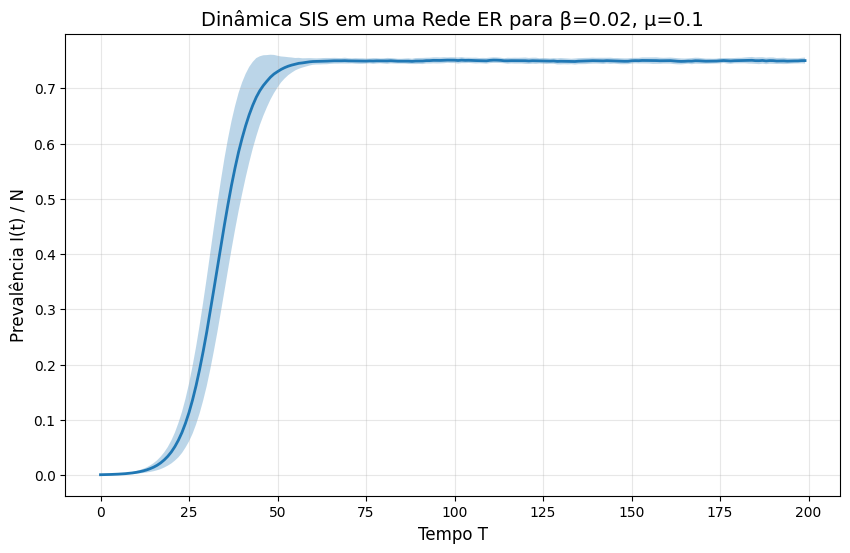

Simulando: β=0.02, μ=0.4 (R0 ≈ 1.00)


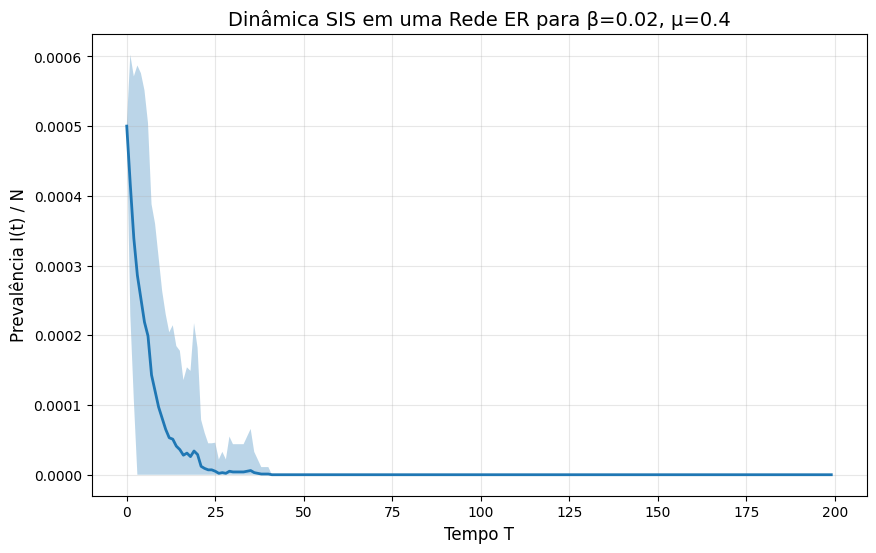

Simulando: β=0.02, μ=0.5 (R0 ≈ 0.80)


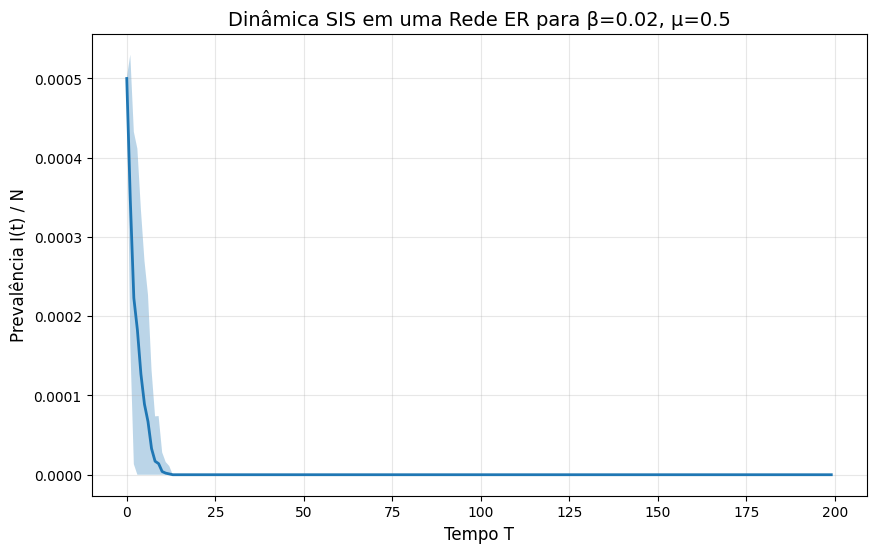

In [ ]:
scenarios = [(0.02, 0.1), (0.02, 0.4), (0.02, 0.5)]

results = {}
degree_mean = emp_k


for beta, mu in scenarios:
    R0 = (beta * degree_mean) / mu

    print(f"Simulando: β={beta}, μ={mu} (R0 ≈ {R0:.2f})")

    mean_prev, std_prev = simulate_SIS_sparse(A, beta, mu, T=200, runs=100)
    results[(beta, mu)] = (mean_prev, std_prev, R0)

    plt.figure(figsize=(10, 6))
    steps = np.arange(len(mean_prev))
    plt.plot(
        steps,
        mean_prev,
        linewidth=2,
    )
    plt.fill_between(
        steps,
        np.maximum(0, mean_prev - std_prev),
        np.minimum(1, mean_prev + std_prev),
        alpha=0.3,
    )
    plt.title(
        f"Dinâmica SIS em uma Rede ER para β={beta}, μ={mu}", fontsize=14
    )
    plt.xlabel("Tempo T", fontsize=12)
    plt.ylabel("Prevalência I(t) / N", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
data_rows = []
for (beta, mu), (mean_arr, std_arr, R0) in results.items():
    final_prev = mean_arr[-20:].mean()
    final_std = std_arr[-20:].mean()

    theoretical_prev = max(0, 1 - (1 / R0)) if R0 > 0 else 0

    data_rows.append(
        {
            "β": beta,
            "μ": mu,
            "R0 Estimado": round(R0, 2),
            "Prevalência Simulada (final)": round(final_prev, 4),
            "Prevalência Teórica (1 - 1/R0)": round(theoretical_prev, 4),
        }
    )

df_results = pd.DataFrame(data_rows)
display(df_results)

,β,μ,R0 Estimado,Prevalência Simulada (final),Prevalência Teórica (1 - 1/R0)
0,0.02,0.1,3.99,0.75,0.7496
1,0.02,0.4,1.00,0.00,0.0000
2,0.02,0.5,0.80,0.00,0.0000


### Discussão dos Resultados

O modelo SIS em uma rede homogênea (como a rede aleatória Erdős-Rényi gerada, onde a distribuição de graus é de Poisson e bem comportada em torno da média $\langle k \rangle \approx 20$) segue de perto as previsões da teoria de campo médio.

O parâmetro fundamental para determinar o comportamento da epidemia é o número básico de reprodução, dado por:
$$R_0 = \frac{\beta \langle k \rangle}{\mu}$$

Onde:

1.  Se **$R_0 > 1$**: A epidemia atinge um estado endêmico estável com prevalência $i = 1 - \frac{1}{R_0}$.
2.  Se **$R_0 \le 1$**: A doença não consegue se sustentar e a prevalência tende a zero (estado livre de doença).

#### 1. Análise dos Cenários

Observando o gráfico e a tabela gerada, podemos distinguir claramente os regimes de comportamento da epidemia baseados nos parâmetros fornecidos:

*   **Cenário A ($\beta=0.02, \mu=0.1$) - Endêmico:**

    * Temos $R_0 = \frac{0.02 \times 20}{0.1} = 4.0$.
    *   Aqui, o $R_0 \approx 4.0$. Como $R_0 > 1$, a doença se espalha rapidamente e atinge um equilíbrio estável onde cerca de **75%** da rede permanece infectada. A simulação converge muito próximo do valor teórico de campo médio ($1 - 1/4 = 0.75$).
*   **Cenário B ($\beta=0.02, \mu=0.4$) - Crítico/Transição:**

    * Temos $R_0 = \frac{0.02 \times 20}{0.4} = 1.0$.
    *   Neste caso, $R_0 \approx 1.0$. Estamos no limiar da transição de fase. Teoricamente, a prevalência tenderia a zero ou seria instável. Na simulação finita, vemos uma prevalência muito baixa ou nula. A infecção luta para sobreviver e, devido a flutuações estocásticas, tende a extinguir-se rapidamente.
*   **Cenário C ($\beta=0.02, \mu=0.5$) - Livre de Doença:**
    
    * Temos $R_0 = \frac{0.02 \times 20}{0.5} = 0.8$.
    *   Aqui, $R_0 \approx 0.8$. Como $R_0 < 1$, a taxa de recuperação supera a capacidade de infecção. A epidemia não consegue se sustentar e decai exponencialmente para zero logo após o início.


**Conclusão:**
Os experimentos numéricos validam a condição de limiar epidêmico. A doença só se fixa na rede (torna-se endêmica) quando a taxa de infecção ponderada pela conectividade média supera a taxa de recuperação ($R_0 > 1$), conforme previsto pela equação de campo médio para redes homogêneas. Os resultados da simulação confirmam esta análise, onde apenas o cenário com $R_0=4$ manteve uma população infectada significativa.

## Questão 02

Rede criada: n=10000, <k>=18.96, <k²>=3179.29


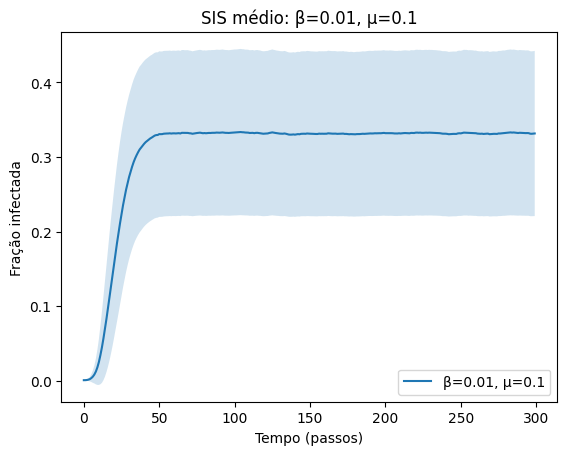

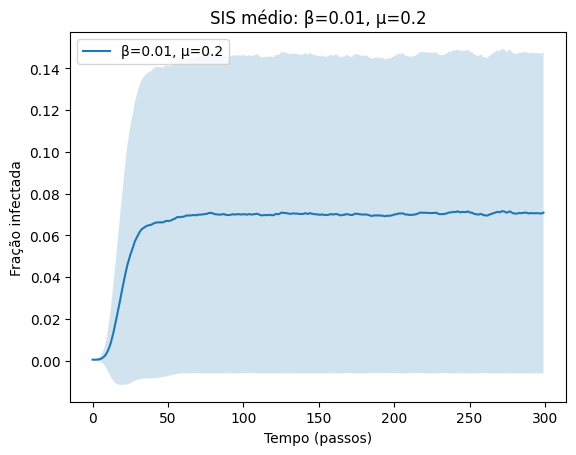

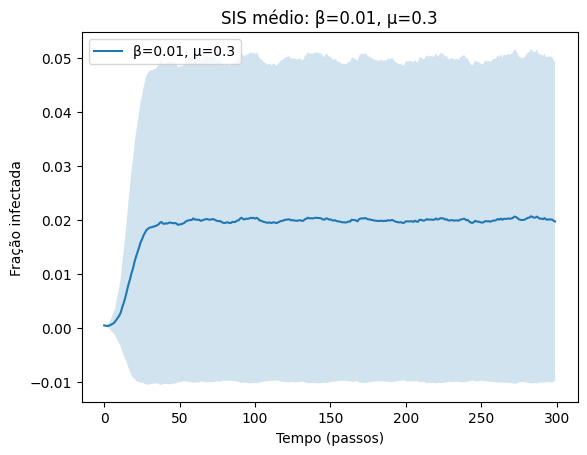

      β    μ       β/μ  Prevalência média  Desvio-padrão
0  0.01  0.1  0.100000           0.331913       0.110900
1  0.01  0.2  0.050000           0.070647       0.076699
2  0.01  0.3  0.033333           0.020023       0.030029


In [ ]:
n = 10_000
gamma = 2.5
target_k = 20.0
rng = np.random.default_rng(42)

# Rede livre de escala
def sample_powerlaw_degrees(n, gamma, target_mean):
    alpha = gamma - 1.0
    xm = target_mean * (alpha - 1.0) / alpha
    vals = (rng.pareto(alpha, size=n) + 1) * xm
    degs = np.rint(vals).astype(int)
    degs[degs < 1] = 1
    if degs.sum() % 2 == 1:
        degs[0] += 1
    return degs

degrees = sample_powerlaw_degrees(n, gamma, target_k)
G = nx.expected_degree_graph(degrees.tolist(), selfloops=False)
A = nx.to_scipy_sparse_array(G, format="csr", dtype=np.int8)

deg_list = np.array([d for _, d in G.degree()])
emp_k = deg_list.mean()
emp_k2 = np.mean(deg_list.astype(float)**2)
print(f"Rede criada: n={n}, <k>={emp_k:.2f}, <k²>={emp_k2:.2f}")

# Simulação SIS (100 execuções)
def simulate_SIS_sparse(A, beta, mu, T=300, runs=100):
    rng_local = np.random.default_rng(123)
    n = A.shape[0]
    prevalence_runs = np.zeros((runs, T))

    for r in range(runs):
        infected = np.zeros(n, dtype=bool)
        infected[rng_local.choice(n, 5, replace=False)] = True

        for t in range(T):
            prevalence_runs[r, t] = infected.mean()

            # recuperação
            recover = infected & (rng_local.random(n) < mu)
            infected[recover] = False

            # infecção
            inf_counts = A.dot(infected.astype(np.int8))
            susceptible = ~infected
            k_inf = inf_counts[susceptible]
            p_inf = 1.0 - np.power(1.0 - beta, k_inf)
            new_inf = rng_local.random(len(k_inf)) < p_inf
            infected[susceptible] = new_inf

    mean_prev = prevalence_runs.mean(axis=0)
    std_prev = prevalence_runs.std(axis=0)
    return mean_prev, std_prev

# Executando simulações com os diferentes parâmetros
params = [(0.01, 0.1), (0.01, 0.2), (0.01, 0.3)]
results = {}

for beta, mu in params:
    mean_prev, std_prev = simulate_SIS_sparse(A, beta, mu)
    results[(beta, mu)] = (mean_prev, std_prev)
    plt.figure()
    plt.plot(mean_prev, label=f"β={beta}, μ={mu}")
    plt.fill_between(np.arange(len(mean_prev)), mean_prev-std_prev, mean_prev+std_prev, alpha=0.2)
    plt.xlabel("Tempo (passos)")
    plt.ylabel("Fração infectada")
    plt.title(f"SIS médio: β={beta}, μ={mu}")
    plt.legend()
    plt.show()

# Resultados
rows = []
for beta, mu in params:
    mean_prev, std_prev = results[(beta, mu)]
    ss_mean = mean_prev[-100:].mean()
    ss_std = std_prev[-100:].mean()
    tau = beta / mu
    rows.append({
        "β": beta, "μ": mu, "β/μ": tau,
        "Prevalência média": ss_mean,
        "Desvio-padrão": ss_std
    })

df = pd.DataFrame(rows)
print(df)


Através da tabela e gráficos acima, podemos observar a diferença nas simulações epidemiológicas variando a **taxa de recuperação μ** enquanto a **taxa de infecção β** permanece constante. 

No cenário onde β = 0.01 e  μ = 0.1 vemos que a infecção é prevalente sobre a recuperação, ou seja, a epidemia se sustenta no tempo com uma prevalência média de 33% nos últimos 100 passos. O desvio-padrão 0.11 indica flutuações entre as simulações, mas com presença contínua de infectados, atingindo assim um estado endêmico estável.

Já no cenário onde β = 0.01 e μ = 0.2 a recuperação é mais rápida, reduzindo a proporção de infectados ativos. A prevalência média nesse caso já cai para cerca de 7%, mostrando que a infecção ainda se mantém, mas em um nível estável baixo. O desvio-padrão menor (0.077) indica uma dinâmica mais estávelentre as simulações.

Por último, o caso onde β = 0.01 e μ = 0.3 a taxa de recuperação é alta, ou seja, a infecção quase não consegue se manter, resultando em uma prevalência baixa (2%). O desvio-padrão pequeno mostra que o sistema está próximo de um estado livre de doença, com infecções esporádicas e transitórias.

Assim, podemos observar que à medida que μ aumenta (probabilidade maior de recuperação) o sistema passa de um regime de alta prevalência para um regime onde a doença desaparece.  

Comparando com a questão acima, que é o caso onde a rede é aleatória, podemos observar que os resultados são muito parecidos. No primeiro cenário onde o μ é baixo temos um estado endêmico que diminui a medida que a taxa de recuperação aumenta.


## Questão 03

In [10]:
def simulate_SIS(G, beta, mu, infected_init, steps=200):
    """
        Simula o modelo SIS na rede G por um número fixo de passos, retornando
        a fração de vértices infectados ao longo do tempo.

        Parâmetros:
            G (networkx.Graph): grafo da rede.
            beta (float): probabilidade de infecção.
            mu (float): probabilidade de recuperação.
            infected_init (iterable): vértices inicialmente infectados.
            steps (int): número de passos da simulação.

        Retorna:
            list: série temporal da fração de vértices infectados.
    """
    infected = set(infected_init)

    history = []

    for _ in range(steps):
        new_infected = set(infected)

        for v in list(infected):
            # recuperação
            if random.random() < mu:
                new_infected.remove(v)

        for v in list(infected):
            for u in G.neighbors(v):
                if u not in new_infected and random.random() < beta:
                    new_infected.add(u)

        infected = new_infected
        history.append(len(infected) / G.number_of_nodes())

    return history


def epidemic_persists(history, threshold=0.01):
    """
        Verifica se a epidemia se fixou avaliando a média dos últimos passos da série.

        Parâmetros:
            history (list): fração de infectados ao longo da simulação.
            threshold (float): limiar mínimo para considerar persistência.

        Retorna:
            bool: True se a epidemia se mantém acima do limiar, False caso contrário.
    """
    return np.mean(history[-50:]) > threshold

## Configurações

In [8]:
N = 10000
m = 10
G = nx.barabasi_albert_graph(N, m)

beta = 0.01
mu = 0.1

In [ ]:
deg_list = np.array([d for _, d in G.degree()])
emp_k = deg_list.mean()
print(f"Rede criada: N={N}, k médio={emp_k:.2f}")

Rede criada: N=10000, k médio=19.98


## Questão 03 - A

In [ ]:
def test_fraction_random(G, p, beta, mu, runs=50):
    """
        Remove aleatoriamente uma fração p de vértices e testa se a 
        epidemia se fixa após várias simulações.
        
        Parâmetros:
            G (networkx.Graph): grafo da rede.
            p (float): fração de vértices imunizados aleatoriamente.
            beta (float): taxa de infecção.
            mu (float): taxa de recuperação.
            runs (int): número de simulações independentes.
        
        Retorna:
            float: fração de simulações em que a epidemia se mantém endêmica.
    """
    N = G.number_of_nodes()
    num_remove = int(p * N)
    remove = random.sample(list(G.nodes()), num_remove)

    G2 = G.copy()
    G2.remove_nodes_from(remove)

    survives = 0
    for _ in range(runs):
        infected_init = random.sample(list(G2.nodes()), 5)
        hist = simulate_SIS(G2, beta, mu, infected_init)
        if epidemic_persists(hist):
            survives += 1

    return survives / runs


ps = np.linspace(0, 0.5, 20)
results_a = []

for p in tqdm(ps):
    results_a.append(test_fraction_random(G, p, beta, mu))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [14:03<00:00, 42.15s/it]


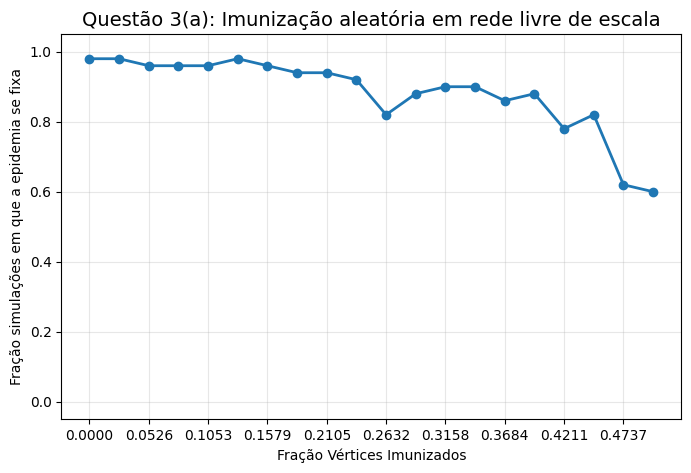

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(ps, results_a, marker='o', linewidth=2)
plt.xlabel("Fração Vértices Imunizados", fontsize=10)
plt.ylabel("Fração simulações em que a epidemia se fixa", fontsize=10)
plt.title("Questão 3(a): Imunização aleatória em rede livre de escala", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(ps[::2])
plt.ylim(-0.05, 1.05)
plt.show()

## Questão 3 - B

In [ ]:
degree_list = sorted(G.degree(), key=lambda x: x[1], reverse=True)
nodes_by_degree = [v for v, d in degree_list]

def test_fraction_hubs(G, p, beta, mu, runs=50):
    """
        Remove a fração p dos vértices de maior grau e testa se a 
        epidemia se fixa após várias simulações.
        
        Parâmetros:
            G (networkx.Graph): grafo da rede.
            p (float): fração de hubs a serem imunizados (maiores graus).
            beta (float): taxa de infecção.
            mu (float): taxa de recuperação.
            runs (int): número de simulações independentes.
        
        Retorna:
            float: fração de simulações em que a epidemia se mantém endêmica.
    """
    N = G.number_of_nodes()
    num_remove = int(p * N)

    remove = nodes_by_degree[:num_remove]

    G2 = G.copy()
    G2.remove_nodes_from(remove)

    survives = 0
    for _ in range(runs):
        infected_init = random.sample(list(G2.nodes()), 5)
        hist = simulate_SIS(G2, beta, mu, infected_init)
        if epidemic_persists(hist):
            survives += 1

    return survives / runs


ps2 = np.linspace(0, 0.2, 20)
results_b = []

for p in tqdm(ps2):
    results_b.append(test_fraction_hubs(G, p, beta, mu))


100%|██████████| 20/20 [03:24<00:00, 10.23s/it]


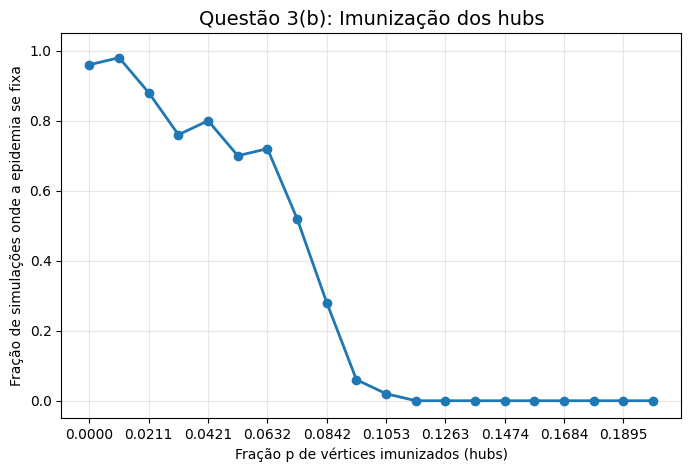

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(ps2, results_b, marker='o', linewidth=2)
plt.xlabel("Fração p de vértices imunizados (hubs)", fontsize=10)
plt.ylabel("Fração de simulações onde a epidemia se fixa", fontsize=10)
plt.title("Questão 3(b): Imunização dos hubs", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(ps2[::2])
plt.ylim(-0.05, 1.05)
plt.show()

## Questão 3 - C

In [ ]:
def pick_neighbors(G, p_seed):
    """
    Seleciona uma fração p_seed de vértices aleatórios e retorna 
    o conjunto de TODOS os seus vizinhos (para serem imunizados).
    """
    N = G.number_of_nodes()
    k = int(p_seed * N)
    
    seeds = random.sample(list(G.nodes()), k)
    
    immunized = set()
    for s in seeds:
        for nb in G.neighbors(s):
            immunized.add(nb)
            
    return immunized

def test_neighbors_strategy(G, p_seed, beta, mu, runs=50):

    immunized = pick_neighbors(G, p_seed)
    
    real_fraction = len(immunized) / G.number_of_nodes()
    
    G2 = G.copy()
    G2.remove_nodes_from(immunized)

    survives = 0
    for _ in range(runs):
        if G2.number_of_nodes() > 5:
            infected_init = random.sample(list(G2.nodes()), 5)
            hist = simulate_SIS(G2, beta, mu, infected_init)
            if epidemic_persists(hist):
                survives += 1
        else:
            pass

    survival_rate = survives / runs
    return real_fraction, survival_rate

ps3 = np.linspace(0, 0.05, 20) 

real_x_values = [] 
y_values = [] 

print("Simulando estratégia C (Vizinhos)...")
for p in tqdm(ps3):
    frac_real, surv_rate = test_neighbors_strategy(G, p, beta, mu)
    
    real_x_values.append(frac_real)
    y_values.append(surv_rate)

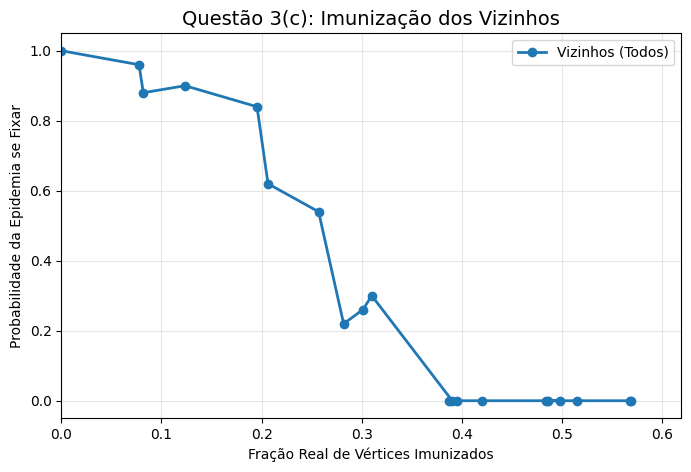

In [15]:
plt.figure(figsize=(8,5))

plt.plot(real_x_values, y_values, marker='o', linewidth=2, label='Vizinhos (Todos)')

plt.xlabel("Fração Real de Vértices Imunizados", fontsize=10)
plt.ylabel("Probabilidade da Epidemia se Fixar", fontsize=10)
plt.title("Questão 3(c): Imunização dos Vizinhos", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.ylim(-0.05, 1.05)
plt.xlim(0, max(real_x_values) + 0.05)

plt.show()

## Conclusão

Para a primeira simulação, em que escolhemos vértices aleatórios para imunizar, observamos que a epidemia continua conseguindo se fixar na maior parte das simulações. Podemos ver no gráfico que apenas para valores bem altos de **p** a doença deixa de se fixar. Isso se deve ao fato de que em redes livres de escala os hubs são de certa forma raros e sendo a imunização aleatória, quase nunca é imunizado um vértice de grau alto. Podemos concluir, que a imunização aleatória é um método ineficiente para para impedir o estado endêmico nesse tipo de rede.

Ao contrário da alternativa anterior, quando imunizamos os vértices de maior grau, podemos observar no gráfico uma queda muito rápida na capacidade da epidemia se fixar. Para um **p** pequeno já conseguimos ver a incapacidade da epidemia de se sustentar. Para algo em torno de 7%, temos o ponto em que em 50% das simulações ela se fixa e 50% não, a partir dali, logo em 10%, quebramos totalmente a estrutura que sustenta o estado endêmico. Essas simulações vão bater com a teoria das redes livre de escala que diz os hubs são os principais responsáveis pela conectividade global e, no nosso caso, pela persistência da doença, já que concentram grande parte do fluxo de contágio. Nesse tipo de rede, imunizar os hubs, se mostrou a estratégia mais eficiente. 

Nas simulações, essa se mostrou ser em termos de eficiência a intermediária entre as três. A epidemia deixa de se fixar completamente com 40% de imunizados, despencando para zero antes do cenário A, mas depois do cenário B (com a imunização direta dos hubs). Isso pode indicar que ao selecionar os vizinhos, podemos estar selecionando de forma indireta os vértices de maior grau e atacando os hubs.

Por fim, os resultados confirmam o comportamento típico de redes livre de escala: elas são altamente robustas a falhas aleatórias, o que explica por que imunizar vértices aleatórios exige uma fração muito grande de vacinados. Porém, elas são extremamente frágeis a ataques direcionados, o que aparece principalmente na imunização dos hubs, mas também na dos vizinhos (acredito que atingiram os hubs indiretamente). Mostrando que a fração de vértices imunizados necessários para impedir que a epidemia se fixe, é drasticamente menor quando atacamos de forma estruturada ao invés de uma forma aleatória. 